In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [3]:
cl_names = ['unsafe', 'safe']
cl_labels = {clname: i for i, clname in enumerate(cl_names)}

In [4]:
cl_labels

{'safe': 1, 'unsafe': 0}

In [5]:
IM_SIZE = (150, 150)

In [6]:
def load_data():
  DIR = '/content/drive/My Drive/My data files/people_classification'
  DATASETS = ['train', 'test']
  output = []

  for dataset in DATASETS:
    data_path = os.path.join(DIR, dataset)
    img_list = []
    label_list = []

    for item in os.listdir(data_path):
      label_name = cl_labels[item]
      
      for image in os.listdir(os.path.join(data_path, item)):
        image_path = os.path.join(os.path.join(data_path, item), image)
        if os.path.isfile(image_path) and image != '.DS_Store':
          img = cv2.imread(image_path)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = cv2.resize(img, IM_SIZE)

          label_list.append(label_name)
          img_list.append(img)
    img = np.array(img_list, dtype='float32')
    label = np.array(label_list, dtype='int32')
    output.append((img, label))
  return output

In [7]:
(train_img, train_label), (test_img, test_label) = load_data()

In [8]:
train_img, train_label = shuffle(train_img, train_label, random_state=25)

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(2,activation=tf.nn.softmax)
])

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(train_img, train_label, batch_size=50, epochs=10, validation_split=0.2)

Epoch 1/10
14/14 [==============================] - 13s 64ms/step - loss: 308.3659 - accuracy: 0.4970 - val_loss: 10.2370 - val_accuracy: 0.3394
Epoch 2/10
14/14 [==============================] - 0s 33ms/step - loss: 18.4239 - accuracy: 0.6079 - val_loss: 0.6929 - val_accuracy: 0.6242
Epoch 3/10
14/14 [==============================] - 0s 34ms/step - loss: 1.1955 - accuracy: 0.5365 - val_loss: 0.6865 - val_accuracy: 0.6848
Epoch 4/10
14/14 [==============================] - 0s 33ms/step - loss: 0.6541 - accuracy: 0.6763 - val_loss: 0.6858 - val_accuracy: 0.6909
Epoch 5/10
14/14 [==============================] - 0s 33ms/step - loss: 0.6150 - accuracy: 0.7036 - val_loss: 0.6844 - val_accuracy: 0.6909
Epoch 6/10
14/14 [==============================] - 0s 33ms/step - loss: 0.5771 - accuracy: 0.7356 - val_loss: 0.6819 - val_accuracy: 0.6848
Epoch 7/10
14/14 [==============================] - 0s 33ms/step - loss: 0.5503 - accuracy: 0.7295 - val_loss: 0.6798 - val_accuracy: 0.6909
Epoch 8/

In [12]:
test_loss = model.evaluate(test_img, test_label)

2/2 [==============================] - 0s 91ms/step - loss: 0.6998 - accuracy: 0.4651


In [13]:
predictions = model.predict(test_img)

In [14]:
predicted_labels = np.argmax(predictions, axis=1)

In [15]:
predicted_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [27]:
def get_prep_img(img_path):
  list_item = []
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, IM_SIZE)
  list_item.append(img)
  np_arr = np.array(list_item, dtype='float32')
  return np_arr

In [18]:
def plot_loss_accuracy(history):
  fig = plt.figure(figsize=(20, 10))
  plt.subplot(221)
  plt.plot(history.history['accuracy'], 'bo--', label='accuracy')
  plt.plot(history.history['val_accuracy'], 'ro--', label='val_accuracy')
  plt.title('train_accuracy vs val_accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()

  plt.subplot(222)
  plt.plot(history.history['loss'], 'bo--', label='loss')
  plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.show()

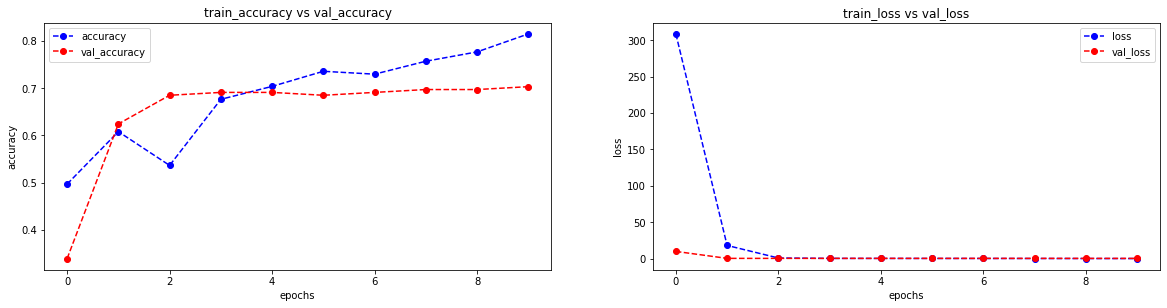

In [19]:
plot_loss_accuracy(history)

In [20]:
!pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 22.4 MB/s 


In [21]:
from kerastuner.tuners import RandomSearch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [22]:
def build_model(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
  model.add(tf.keras.layers.MaxPooling2D(2,2))
  if hp.Boolean("dropout"):
    model.add(tf.keras.layers.Dropout(rate=0.25))
  model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2,2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=hp.Int("units", min_value=64, max_value=512, step=32),
            activation=hp.Choice("activation", ["relu", "tanh"])))
  model.add(tf.keras.layers.Dense(units=hp.Int("units", min_value=32, max_value=128, step=32), activation=tf.nn.relu))
  model.add(tf.keras.layers.Dense(2,activation=tf.nn.softmax))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32)

tuner.search(train_img, train_label, epochs=10, batch_size=50, validation_data=(test_img, test_label))

Trial 28 Complete [00h 00m 08s]
val_accuracy: 0.5581395626068115

Best val_accuracy So Far: 0.8372092843055725
Total elapsed time: 00h 03m 41s
INFO:tensorflow:Oracle triggered exit


In [23]:
best_model = tuner.get_best_models()[0]

In [24]:
best_model.evaluate(test_img, test_label)

2/2 [==============================] - 0s 8ms/step - loss: 0.4663 - accuracy: 0.8372


[0.4663117825984955, 0.8372092843055725]

In [25]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 160)               6

In [26]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: False
units: 160
activation: relu
Score: 0.8372092843055725
Trial summary
Hyperparameters:
dropout: False
units: 256
activation: relu
Score: 0.8372092843055725
Trial summary
Hyperparameters:
dropout: False
units: 96
activation: relu
Score: 0.8139534592628479
Trial summary
Hyperparameters:
dropout: False
units: 128
activation: relu
Score: 0.7441860437393188
Trial summary
Hyperparameters:
dropout: True
units: 96
activation: relu
Score: 0.7441860437393188
Trial summary
Hyperparameters:
dropout: False
units: 384
activation: relu
Score: 0.7209302186965942
Trial summary
Hyperparameters:
dropout: True
units: 64
activation: relu
Score: 0.6511628031730652
Trial summary
Hyperparameters:
dropout: False
units: 352
activation: tanh
Score: 0.604651153087616
Trial summary
Hyperparameters:
dropout: True
units: 512
activation: relu
Score: 0.604651153087616
Trial summary
Hyperparameters:
dropout:

In [43]:
def predict_show(path_im):
  img_arr = get_prep_img(path_im)
  img_recon = cv2.imread(path_im)
  img_recon = cv2.cvtColor(img_recon, cv2.COLOR_BGR2RGB)
  img_recon = cv2.resize(img_recon, IM_SIZE)
  plt.imshow(img_recon)
  plt.show()
  predictions = best_model.predict(img_arr)
  predicted_labels = np.argmax(predictions, axis=1)
  if predicted_labels[0] == 1:
    print('SAFE')
  else:
    print('UNSAFE')

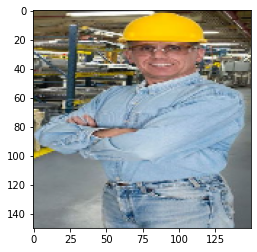

SAFE


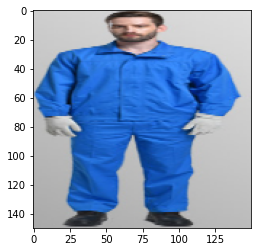

UNSAFE


In [44]:
predict_show('/content/drive/My Drive/My data files/people_classification/safe.jpg')
predict_show('/content/drive/My Drive/My data files/people_classification/unsafe.jpeg')